In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:50]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = deepcopy(data1)

data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

In [ ]:
import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

In [ ]:
data_all.shape

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>10:
        return [],[],[],[],[],[],[]
    ecg_rr[np.isnan(ecg_rr)] = np.nanmean(ecg_rr)
    m = np.mean(ecg_rr[ecg_rr>0])
    s = np.mean(ecg_rr[ecg_rr>0])
    if len(ecg_rr)<60:
        return [],[],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    weights = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<30:
            continue
        index = np.isnan(ppg_rr)
        ppg_qual[index] = -1
        index = np.isnan(ppg_qual)
        ppg_qual[index] = -1
        tmp = a[:,np.array([-2,-3,-4,-5,-6,-7,-8,-9,1])].reshape(60,9)
        for k in range(4):
            tmp[np.isnan(tmp[:,k]),k] = np.nanmean(tmp[:,k])
            tmp[tmp[:,k]==0,k] = np.mean(tmp[tmp[:,k]>0,k])
        tmp[np.isnan(tmp)] = 0
        y.append(tmp[:,0].reshape(1,60,1))
        X.append(tmp.reshape(1,60,9))
        means.append(m)
        stds.append(s)
        weights.append(np.abs(tmp[:,0]-ecg_rr).reshape(1,60,1))
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
    return X,y,ecg,means,stds,quals,weights

unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    return df.reshape(-1,60,11)
def get_all_data(data_user):
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        return []
    df_col = [get_data(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = [get_data1(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20]
    return df_col
# for user in unique_users:
#     data_user = data_all[data_all.user.isin([user])]
all_X = Parallel(n_jobs=20,verbose=3)(delayed(get_all_data)(data_all[data_all.user.isin([user])]) for user in unique_users)

In [ ]:
X,y,ecg,means,stds,quals,weights = [],[],[],[],[],[],[]
for i,b in enumerate(all_X):
    if len(b)==0:
        continue
    for a in b:
        X.extend(a[0])
        y.extend(a[1])
        ecg.extend(a[2])
        means.extend(a[3])
        stds.extend(a[4])
        quals.extend(a[5])
        weights.extend(a[6])

In [ ]:
import pickle
pickle.dump([X,y,ecg,means,stds,quals,weights],open('../data_users/processed_data_weights.p','wb'),protocol=4)

In [84]:
import pandas as pd
import pickle
import os
import numpy as np
X,y,ecg,means,stds,quals,weights = pickle.load(open('../data_users/processed_data_weights.p','rb'))

In [85]:
X,y,ecg,means,stds,quals,weights = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals),np.concatenate(weights).reshape(-1,60)

In [86]:
weights[weights>400] = 400
weights = 1- weights/400
weights[weights<.2] = .2

In [88]:
np.max(weights)

1.0

In [89]:
weights.shape,y.shape
y = np.concatenate([y.reshape(-1,60,1),weights.reshape(-1,60,1)],axis=2)

In [90]:
y.shape

(49938, 60, 2)

In [91]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test1,ecg_train, \
ecg_test,weights_train,weights_test, \
quals_train,quals_test= train_test_split(
    X[:,:,np.array([1,2,3,5,6,7,4])], y,ecg,weights,quals, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val,weights_train,weights_val = train_test_split(
    X_train, y_train,weights_train, test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape,y_test1.shape,y_val.shape,weights_val.shape)

(26766, 60, 7) (26766, 60, 2) (16480, 60, 2) (6692, 60, 2) (6692, 60)


In [92]:
def custom_mae(y_true,y_pred):
    weights = y_true[:,:,1]
    y_true = y_true[:,:,0]
    y_pred = y_pred[:,:,0]
    y_true = K.cast(y_true, y_pred.dtype)
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))
    diff = diff*weights
    return .5*100. * K.mean(diff, axis=-1) + .5*losses.mean_absolute_error(y_true,y_pred)
#     return losses.mean_absolute_error(y_true,y_pred)

timesteps = 60
input_dim = 7
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(GRU(120,return_sequences=True,activation='relu',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
att = Dense(1,activation='relu')(encoded)

att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(240)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])

encoded = Flatten()(mer)
encoded = Dense(30,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
encoded = RepeatVector(2)(encoded)
encoded = Permute((2,1))(encoded)
sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded])
sequence_autoencoder.compile(optimizer='adam',loss=custom_mae)

sequence_autoencoder.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 60, 7)        0                                            
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 60, 240)      92160       input_7[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 60, 1)        241         bidirectional_7[0][0]            
__________________________________________________________________________________________________
flatten_12 (Flatten)            (None, 60)           0           dense_7[0][0]                    
____________________________________________________________________________________________

In [93]:
filepath = '../models/base_LSTM_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, y_train,
                epochs=200,
                batch_size=500,
                shuffle=True,
                validation_data=(X_val,y_val),callbacks=callbacks_list)

Train on 26766 samples, validate on 6692 samples
Epoch 1/200
26766/26766 [==============================] - 13s 491us/step - loss: 187.3403 - val_loss: 96.0679

Epoch 00001: val_loss improved from inf to 96.06789, saving model to ../models/base_LSTM_weights.hdf5
Epoch 2/200
26766/26766 [==============================] - 11s 403us/step - loss: 89.7470 - val_loss: 86.7403

Epoch 00002: val_loss improved from 96.06789 to 86.74033, saving model to ../models/base_LSTM_weights.hdf5
Epoch 3/200
26766/26766 [==============================] - 10s 375us/step - loss: 84.6202 - val_loss: 83.6237

Epoch 00003: val_loss improved from 86.74033 to 83.62365, saving model to ../models/base_LSTM_weights.hdf5
Epoch 4/200
26766/26766 [==============================] - 10s 379us/step - loss: 83.2386 - val_loss: 83.6369

Epoch 00004: val_loss did not improve from 83.62365
Epoch 5/200
26766/26766 [==============================] - 10s 379us/step - loss: 82.4658 - val_loss: 82.5108

Epoch 00005: val_loss impro

26766/26766 [==============================] - 12s 467us/step - loss: 52.2186 - val_loss: 52.3795

Epoch 00042: val_loss improved from 52.92995 to 52.37953, saving model to ../models/base_LSTM_weights.hdf5
Epoch 43/200
26766/26766 [==============================] - 12s 466us/step - loss: 52.2053 - val_loss: 54.1379

Epoch 00043: val_loss did not improve from 52.37953
Epoch 44/200
26766/26766 [==============================] - 13s 468us/step - loss: 52.2502 - val_loss: 52.2198

Epoch 00044: val_loss improved from 52.37953 to 52.21978, saving model to ../models/base_LSTM_weights.hdf5
Epoch 45/200
26766/26766 [==============================] - 11s 406us/step - loss: 52.1285 - val_loss: 52.2766

Epoch 00045: val_loss did not improve from 52.21978
Epoch 46/200
26766/26766 [==============================] - 10s 378us/step - loss: 52.0245 - val_loss: 52.4921

Epoch 00046: val_loss did not improve from 52.21978
Epoch 47/200
26766/26766 [==============================] - 10s 378us/step - loss: 

26766/26766 [==============================] - 12s 466us/step - loss: 50.2909 - val_loss: 52.7904

Epoch 00087: val_loss did not improve from 50.38052
Epoch 88/200
26766/26766 [==============================] - 11s 419us/step - loss: 50.3527 - val_loss: 50.7686

Epoch 00088: val_loss did not improve from 50.38052
Epoch 89/200
26766/26766 [==============================] - 10s 374us/step - loss: 50.1801 - val_loss: 51.1366

Epoch 00089: val_loss did not improve from 50.38052
Epoch 90/200
26766/26766 [==============================] - 10s 375us/step - loss: 50.5065 - val_loss: 51.0216

Epoch 00090: val_loss did not improve from 50.38052
Epoch 91/200
26766/26766 [==============================] - 10s 379us/step - loss: 50.1741 - val_loss: 50.5331

Epoch 00091: val_loss did not improve from 50.38052
Epoch 92/200
26766/26766 [==============================] - 10s 375us/step - loss: 50.1749 - val_loss: 50.3377

Epoch 00092: val_loss improved from 50.38052 to 50.33772, saving model to ../mode

26766/26766 [==============================] - 10s 380us/step - loss: 48.7121 - val_loss: 48.9205

Epoch 00133: val_loss did not improve from 48.85053
Epoch 134/200
26766/26766 [==============================] - 10s 376us/step - loss: 48.7280 - val_loss: 48.8811

Epoch 00134: val_loss did not improve from 48.85053
Epoch 135/200
26766/26766 [==============================] - 10s 378us/step - loss: 48.5263 - val_loss: 48.7661

Epoch 00135: val_loss improved from 48.85053 to 48.76607, saving model to ../models/base_LSTM_weights.hdf5
Epoch 136/200
26766/26766 [==============================] - 10s 376us/step - loss: 48.5071 - val_loss: 49.2385

Epoch 00136: val_loss did not improve from 48.76607
Epoch 137/200
26766/26766 [==============================] - 10s 377us/step - loss: 48.7135 - val_loss: 48.8809

Epoch 00137: val_loss did not improve from 48.76607
Epoch 138/200
26766/26766 [==============================] - 10s 377us/step - loss: 48.4624 - val_loss: 49.6070

Epoch 00138: val_loss

26766/26766 [==============================] - 10s 376us/step - loss: 47.7637 - val_loss: 49.2835

Epoch 00180: val_loss did not improve from 47.98298
Epoch 181/200
26766/26766 [==============================] - 10s 374us/step - loss: 47.6630 - val_loss: 48.3395

Epoch 00181: val_loss did not improve from 47.98298
Epoch 182/200
26766/26766 [==============================] - 10s 378us/step - loss: 47.8778 - val_loss: 47.9968

Epoch 00182: val_loss did not improve from 47.98298
Epoch 183/200
26766/26766 [==============================] - 10s 376us/step - loss: 47.9765 - val_loss: 49.6352

Epoch 00183: val_loss did not improve from 47.98298
Epoch 184/200
26766/26766 [==============================] - 10s 377us/step - loss: 47.7660 - val_loss: 49.1133

Epoch 00184: val_loss did not improve from 47.98298
Epoch 185/200
26766/26766 [==============================] - 10s 377us/step - loss: 47.6193 - val_loss: 48.5879

Epoch 00185: val_loss did not improve from 47.98298
Epoch 186/200
26766/2676

In [ ]:
from keras.models import load_model
import tensorflow_probability as tfp
sequence_autoencoder = load_model(filepath)

In [94]:
y_train.shape,y_test1.shape

((26766, 60, 2), (16480, 60, 2))

In [95]:
y_pred1 = sequence_autoencoder.predict(X_test)

In [96]:
y_pred1.shape,y_test1.shape

((16480, 60, 2), (16480, 60, 2))

In [97]:
y_pred = y_pred1[:,:,0].reshape(-1,60)
y_test = y_test1[:,:,0].reshape(-1,60)

In [99]:
y_pred[0].shape,y_pred[1].shape,y_pred[2].shape,quals_test[0].shape

((60,), (60,), (60,), (60, 1))

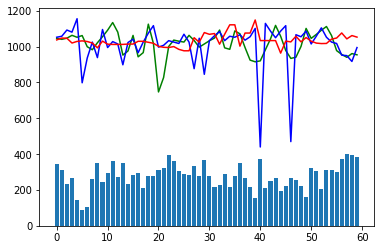

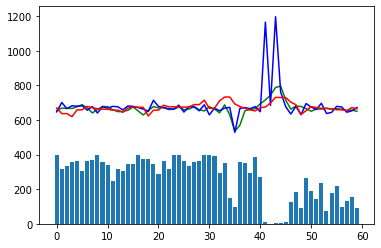

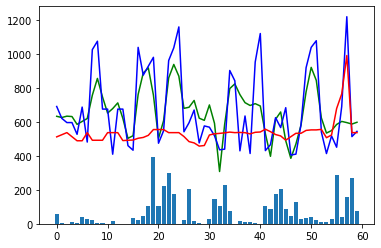

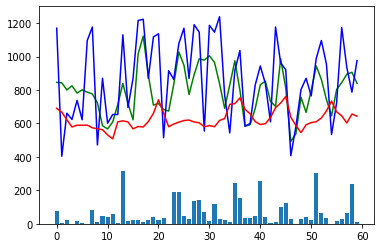

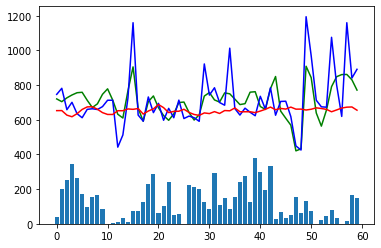

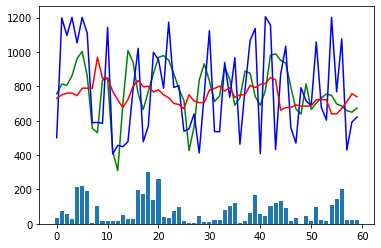

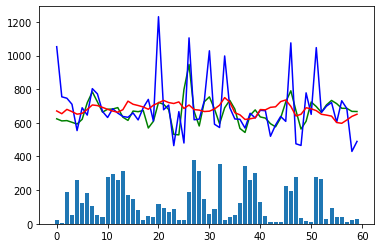

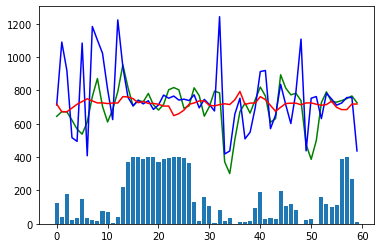

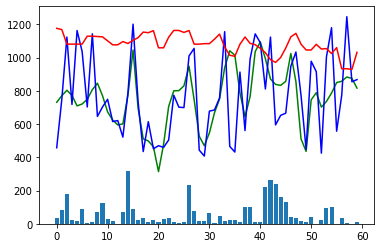

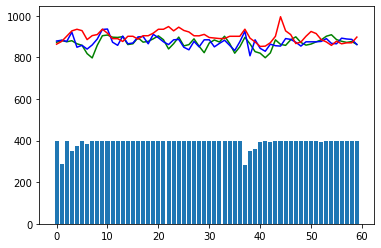

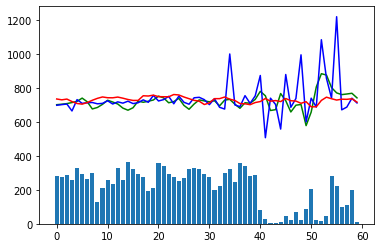

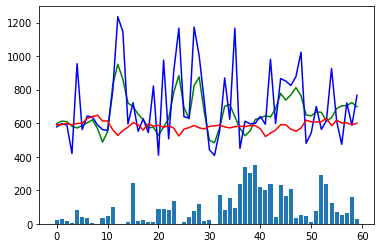

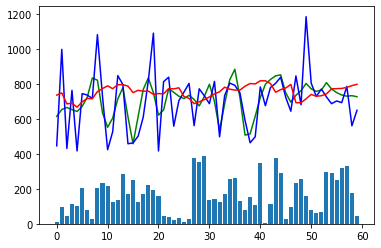

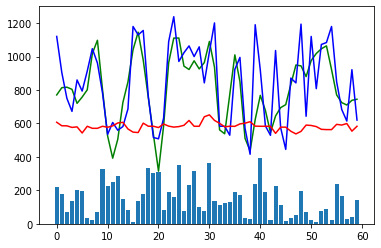

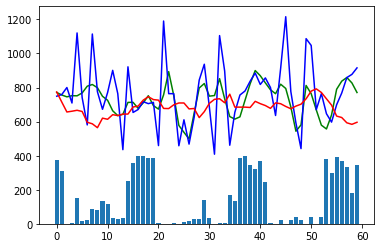

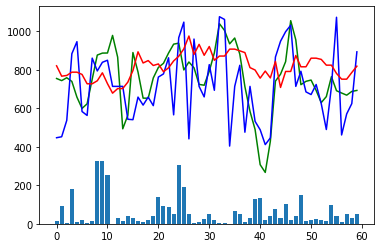

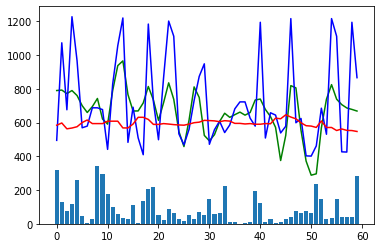

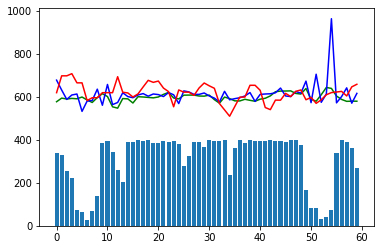

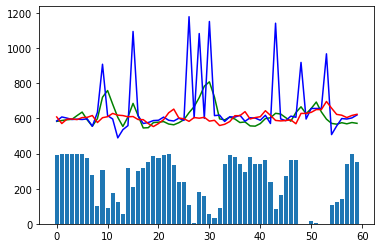

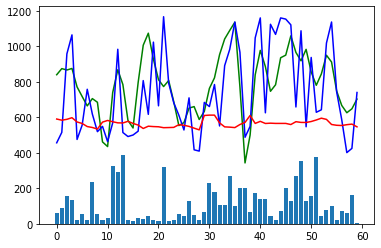

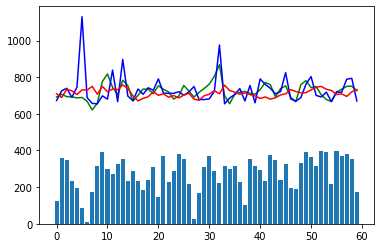

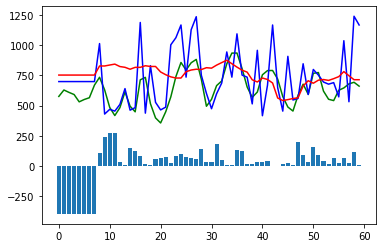

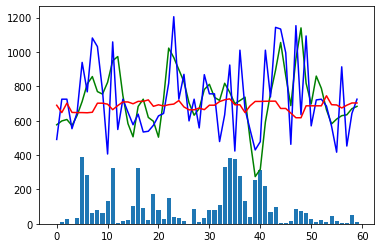

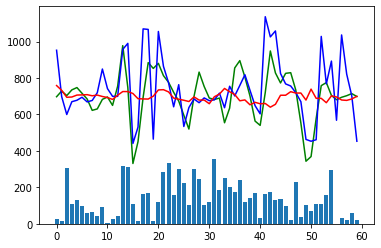

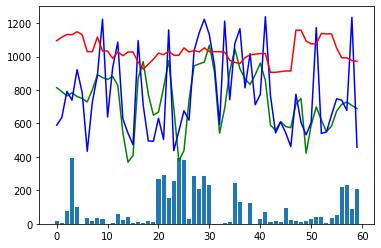

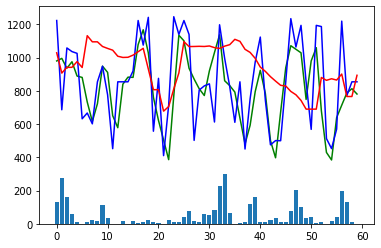

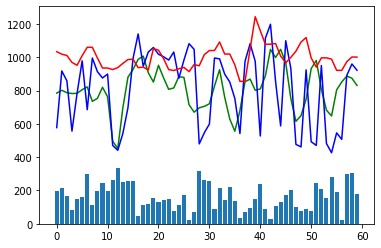

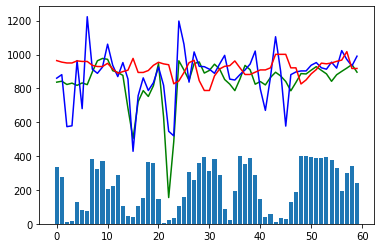

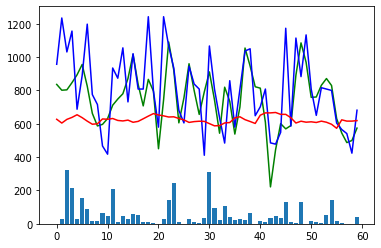

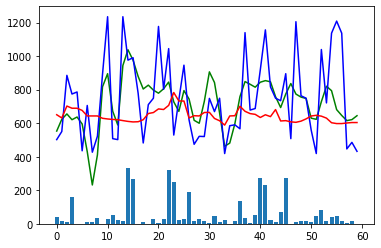

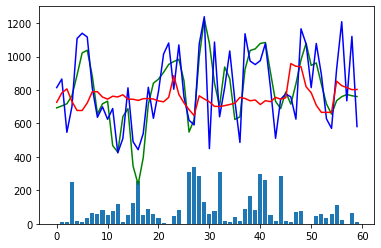

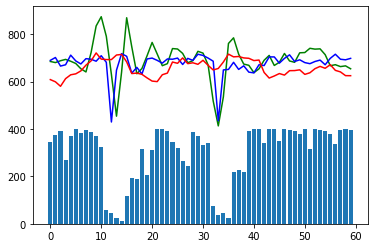

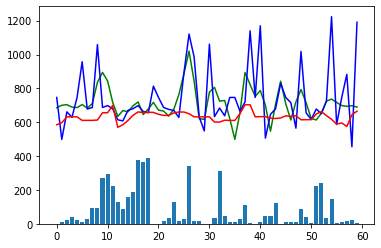

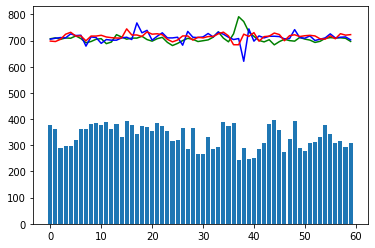

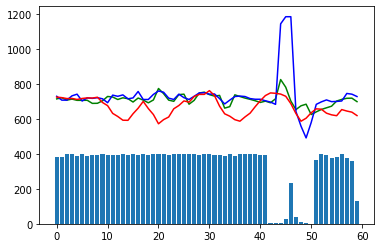

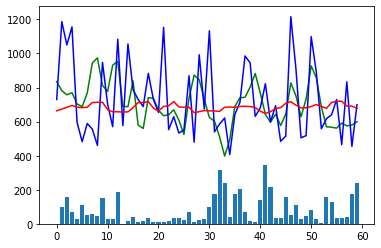

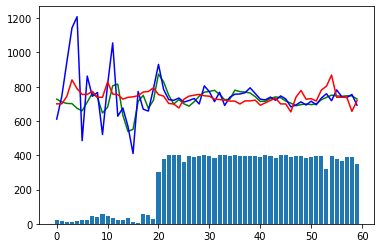

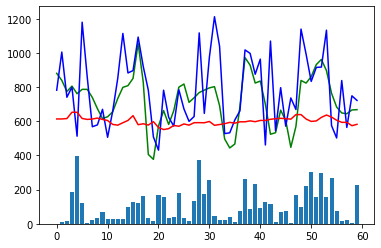

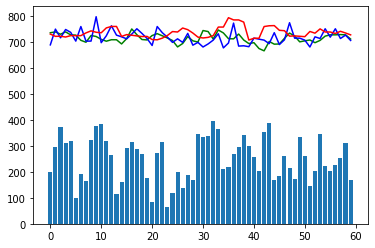

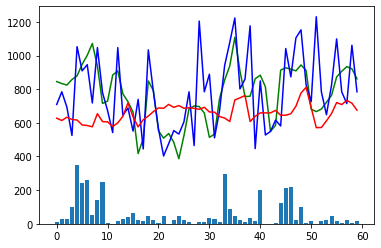

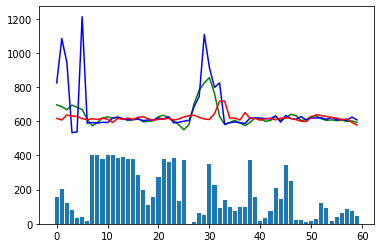

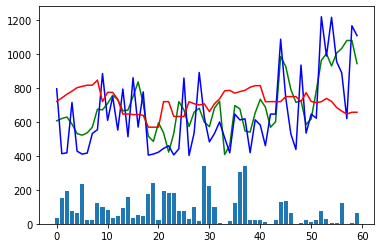

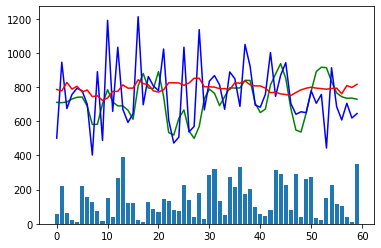

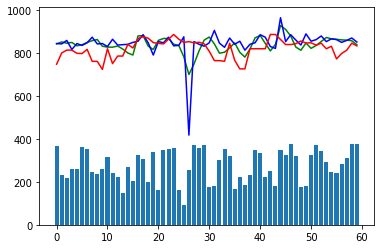

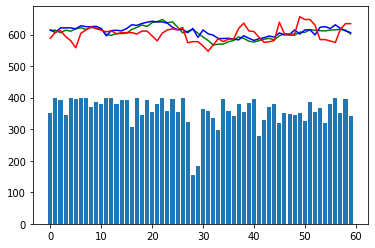

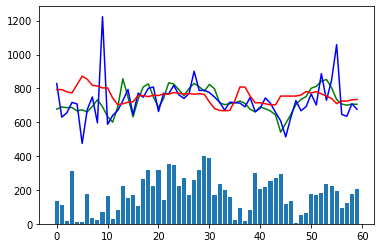

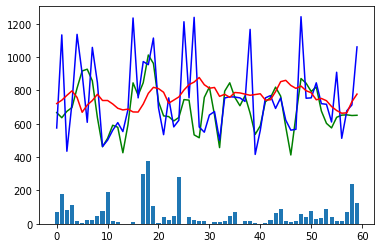

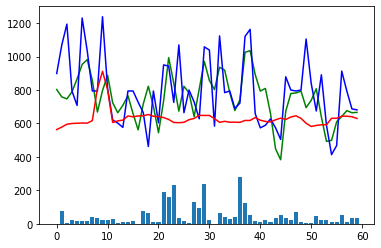

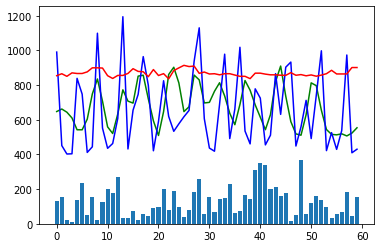

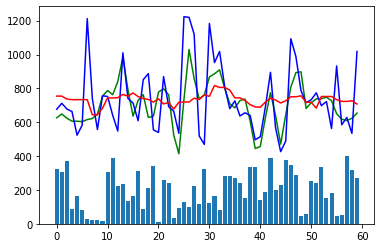

In [100]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[:50]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#     plt.plot(X_test[i,:,:4],'r')
    plt.plot(y_test[i],'b')
#     plt.bar(range(60),y_test[i]*400,.9)
#     plt.bar(range(60),quals_test[i]*400,.45)
    plt.plot(ecg_test[i],'r')
    plt.bar(range(60),quals_test[i][:,0]*400)
    plt.show()

In [101]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [102]:
X = X[X[:,0]>-1]
X = X[X[:,2]>0]
X = X[X[:,3]>0]
X = X[X[:,1]>0]

In [76]:
# plt.hist(X[:,0])
# y_test = y_test[:,:,0]

(218553, 4) 0.0
(142801, 4) 0.05
(81965, 4) 0.1
(53553, 4) 0.15000000000000002
(41818, 4) 0.2
(35647, 4) 0.25
(32698, 4) 0.30000000000000004
(30393, 4) 0.35000000000000003
(28485, 4) 0.4
(27264, 4) 0.45
(25794, 4) 0.5
(24287, 4) 0.55
(23006, 4) 0.6000000000000001
(23123, 4) 0.65
(22646, 4) 0.7000000000000001
(23335, 4) 0.75
(24422, 4) 0.8
(24777, 4) 0.8500000000000001
(29529, 4) 0.9
(53960, 4) 0.9500000000000001
20 20


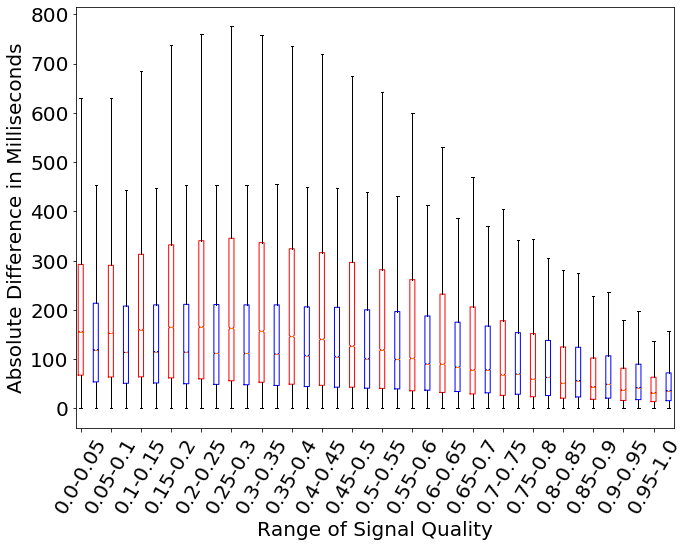

In [103]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [104]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'range_nni'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    ecg_min= ecg_min[~np.isinf(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_pred_min = y_pred_min[~np.isinf(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    y_test_min = y_test_min[~np.isinf(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<10 or len(y_test_min)<10:
        continue
    x.append(np.array(list(get_time_domain_features(y_pred_min).values())))
    y.append(np.array(list(get_time_domain_features(ecg_min).values())))
    z.append(np.array(list(get_time_domain_features(y_test_min).values())))
    q.append(np.mean(qual_min))

/home/azim/.local/lib/python3.6/site-packages/hrvanalysis/extract_features.py:121: RuntimeWarning: divide by zero encountered in true_divide
  heart_rate_list = np.divide(60000, nn_intervals)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [105]:
preds,ecgs,fpreds,q = np.array(x),np.array(y),np.array(z),np.array(q)

In [106]:
preds.shape,ecgs.shape,fpreds.shape,q.shape

((16480, 16), (16480, 16), (16480, 16), (16480,))

In [107]:
preds[:,-5]

array([0.06939183, 0.05459801, 0.20301101, ..., 0.23260607, 0.19023703,
       0.20621207])

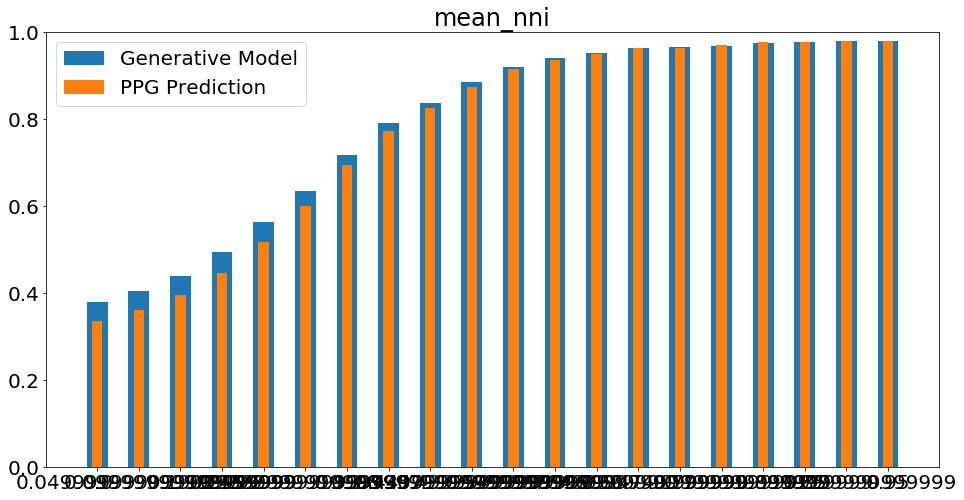

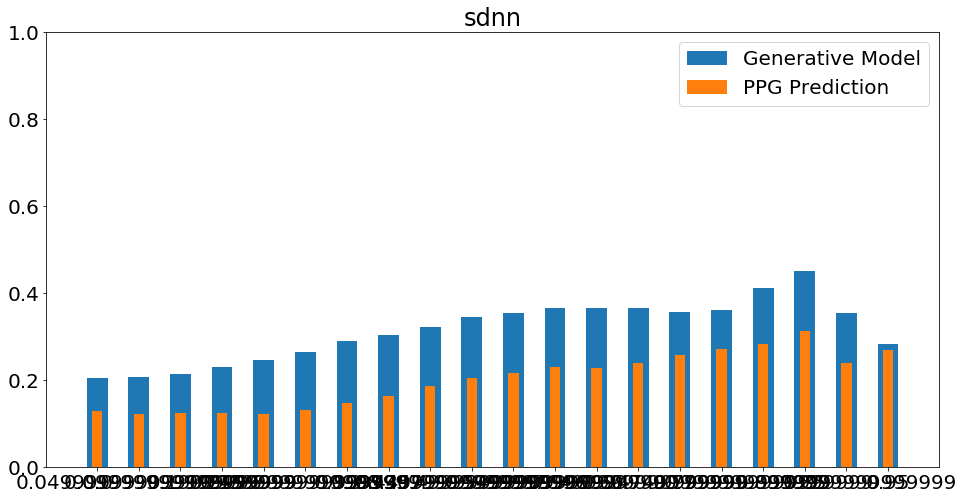

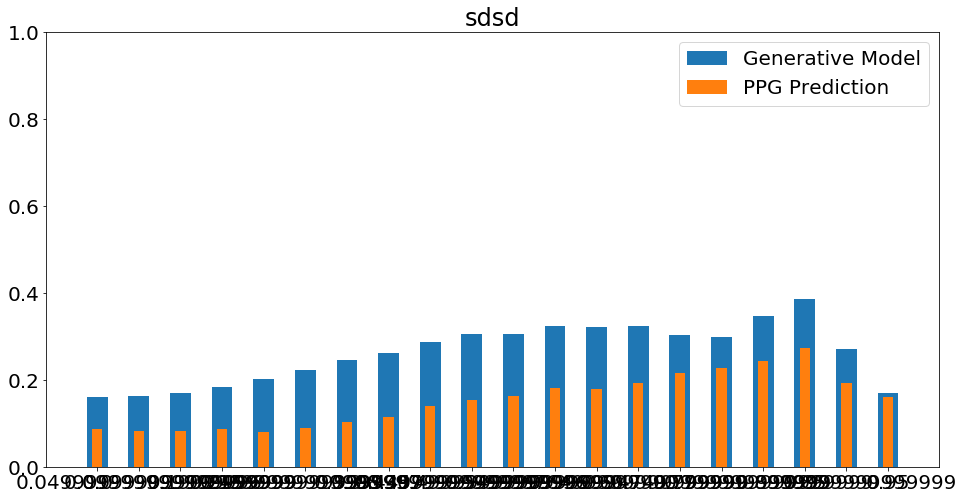

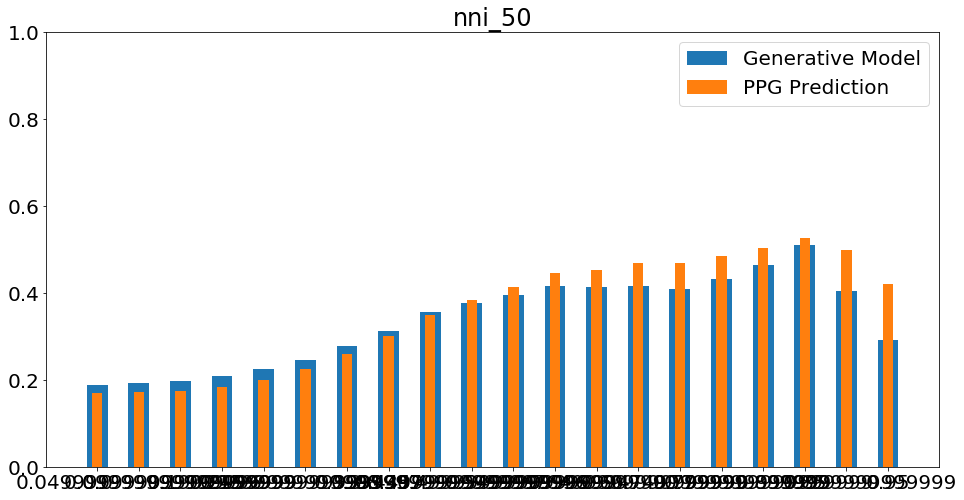

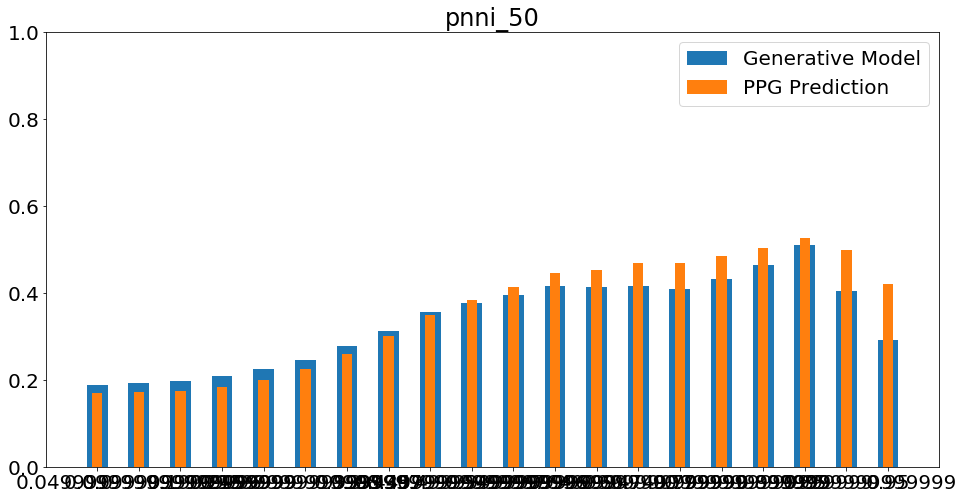

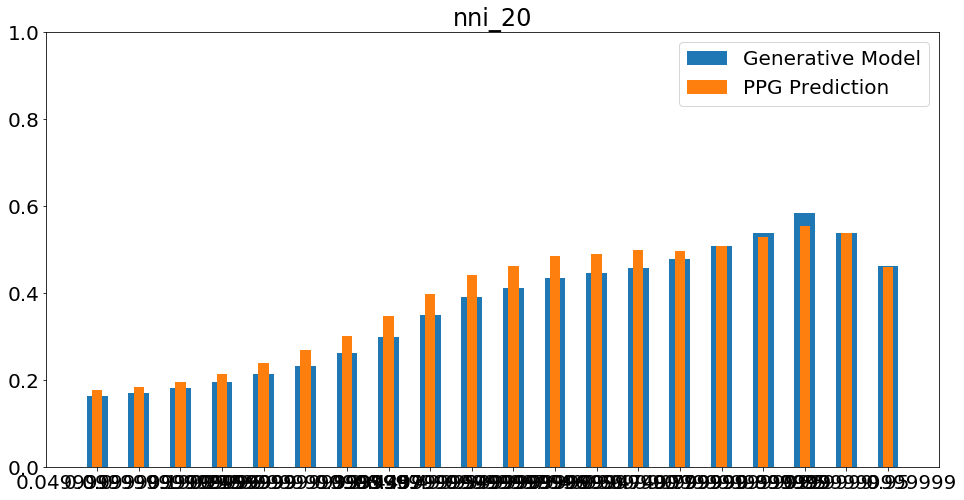

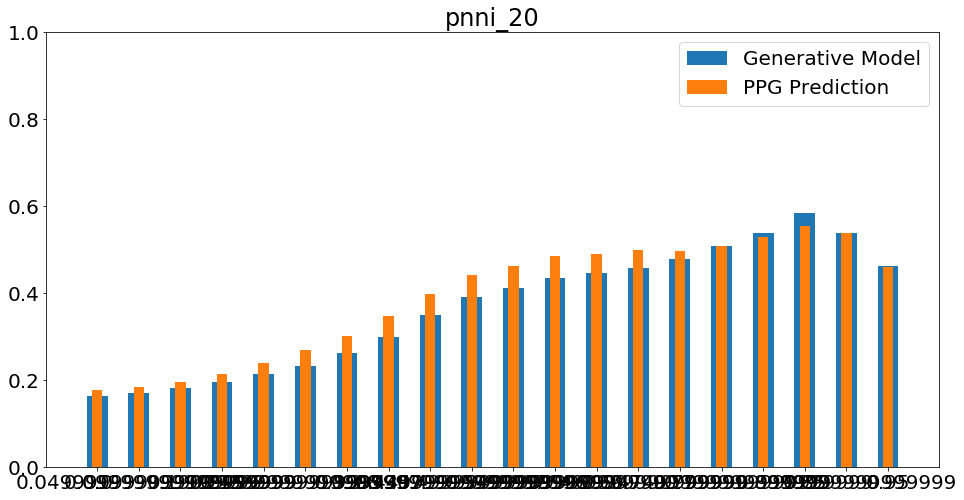

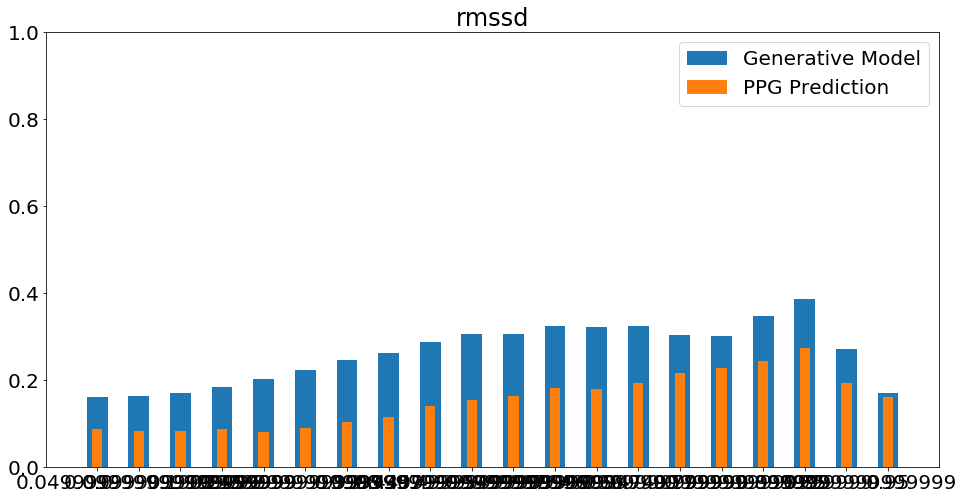

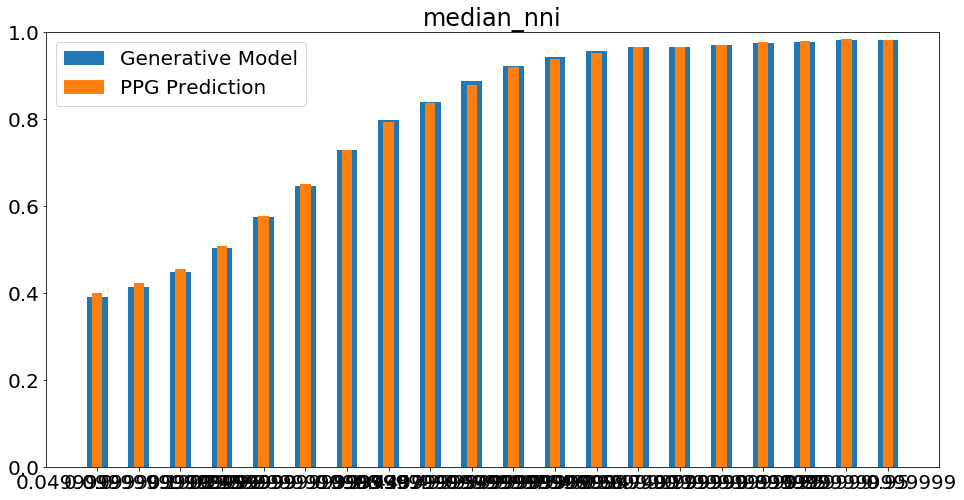

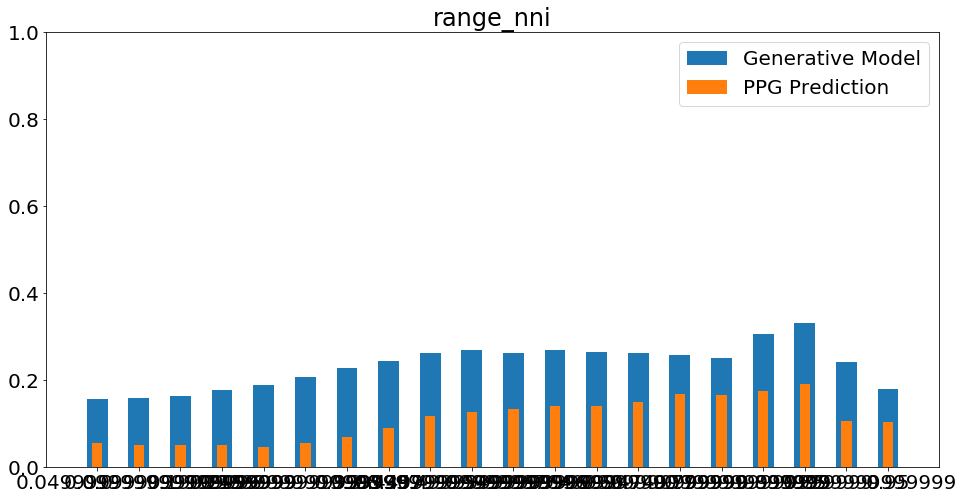

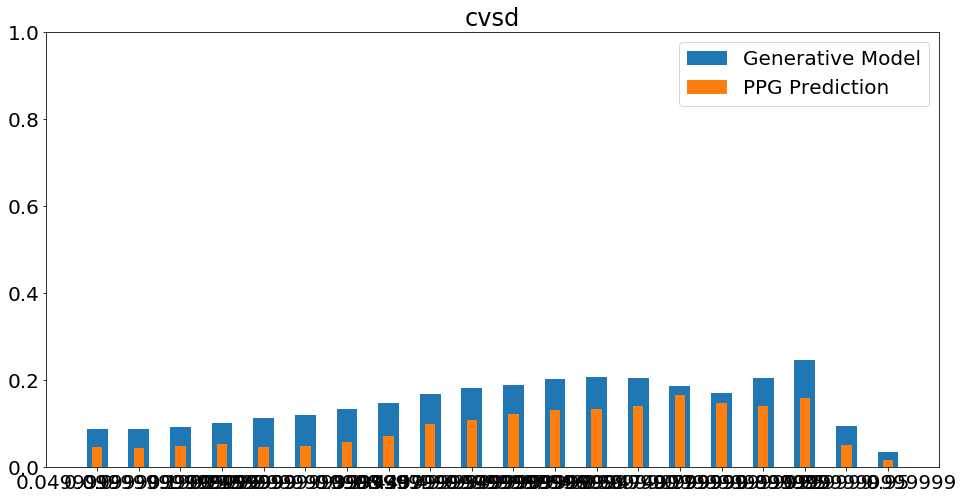

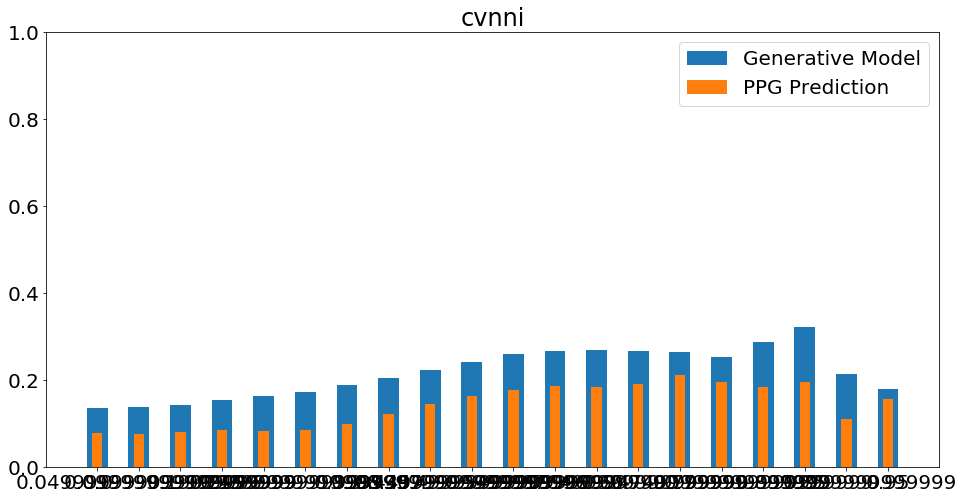

In [108]:
from scipy.stats import pearsonr
feature_col = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd',
 'median_nni', 'range_nni', 'cvsd', 'cvnni']

def get_pearson(x,y):
    index = ~np.isnan(x)
    x,y = x[index],y[index]
    index = ~np.isnan(y)
    x,y = x[index],y[index]
    return pearsonr(x,y)[0]

for j in range(len(feature_col)):
    x = []
    y = []
    y1 = []
    for i in np.linspace(0,.95,20):
        index = np.where((q>=i)&(q<=i+.5))[0]
#         print(len(index))
        if len(index)<10:
            continue
        x.append(str(i))
#         print(pearsonr(ecgs[index,j],preds[index,j])[0])
        try:
            y.append(get_pearson(ecgs[index,j],preds[index,j]))
            y1.append(get_pearson(ecgs[index,j],fpreds[index,j]))
        except:
            continue
    try:
        plt.figure(figsize=(16,8))
        plt.bar(x,y,.5,label='Generative Model')
        plt.bar(x,y1,.25,label='PPG Prediction')
        plt.title(feature_col[j])
        plt.ylim([0,1])
        plt.legend()
        plt.show()
    except Exception as e:
        continue
        

In [ ]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'rmssd'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [ ]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

In [ ]:
plt.hist(quals_test.reshape(-1))

In [ ]:
!pip install --user tensorflow-probability